In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch import distributions
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML

In [2]:
device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 

# Normalising flows: comparison to CNF
In this notebook we compare the performance of CNF to a discrete normalising flow. As with the CNF example, we will learn a two-modal distribution with two concentric circles, and a uniform distribution of a triangle.

The results are compared in [NF_CNF_comparison.md](NF_CNF_comparison.md).
## Hyperparameters

In [3]:
args = {
    'niters': 5000,
    'lr': 1e-4,
    'num_samples': 1000,
}

## The Model

We will use a RealNVP normalising flow with the following architecture:
- Coupling layers with two neural networks: a scale network and a translation network. They will have `LeakyReLU` activations, and the scale network will have a `Tanh` activation at the end.
- Spatial checkerboard masks.
- A number of transformations equal to 6 for the triangle distribution and 14 for the concentric circles distribution.

In [4]:
class CouplingLayer(nn.Module):
    def __init__(self, in_out_dim, hidden_dim, mask, num_layers):
        super(CouplingLayer, self).__init__()
        
        self.mask = nn.Parameter(mask.to(device), requires_grad=False)
        
        self.scale = nn.Sequential( # s network
            nn.Linear(in_out_dim, hidden_dim),
            nn.LeakyReLU(),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(),
            ) for _ in range(num_layers)],
            nn.Linear(hidden_dim, in_out_dim),
            nn.Tanh(),
        )
        
        self.translation = nn.Sequential( # t network
            nn.Linear(in_out_dim, hidden_dim),
            nn.LeakyReLU(),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(),
            ) for _ in range(num_layers)],
            nn.Linear(hidden_dim, in_out_dim),
        )
        
    def forward(self, x):
        masked_x = x * self.mask
        scale = self.scale(masked_x)*(1 - self.mask)
        translation = self.translation(masked_x)*(1 - self.mask)
        
        x = masked_x + (1 - self.mask) * (x * torch.exp(scale) + translation)        
        return x
    
    def inverse(self, x):
        masked_x = self.mask * x
        scale = self.scale(masked_x)*(1 - self.mask)
        translation = self.translation(masked_x)*(1 - self.mask)
        x = (1 - self.mask) * (x - translation) * torch.exp(-scale) + masked_x
        log_det = scale.sum(dim=1)
        return x, log_det
    

            

In [5]:
class NF(nn.Module):
    """RealNVP model with spatial checkerboard mask."""
    
    def __init__(self, in_out_dim, hidden_dim, num_layers, num_transformations):
        super(NF, self).__init__()
        
        self.prior = distributions.MultivariateNormal(torch.zeros(in_out_dim).to(device), torch.eye(in_out_dim).to(device))
        
        mask_even = torch.from_numpy(np.array([0., 1.]).astype(np.float32)).to(device)
        mask_odd = torch.from_numpy(np.array([1., 0.]).astype(np.float32)).to(device)
        
        self.transformations = torch.nn.ModuleList([
            CouplingLayer(in_out_dim, hidden_dim, mask_even if i % 2 == 0 else mask_odd, num_layers)
            for i in range(num_transformations)
        ] )
        
    def inverse(self, x):
        #print("inverse")
        log_det, z = x.new_zeros(x.shape[0]), x
        for i, transform in enumerate(reversed(self.transformations)):
            #print("z shape: ", z.shape)
            z, delta_log_det = transform.inverse(z)
            #print("delta:",delta_log_det.shape)
            #print("log_Det:",log_det.shape)
            log_det -= delta_log_det
        return z, log_det
    
    def log_prob(self, x):
        #print("log_prob")
        z, logp = self.inverse(x)
        return self.prior.log_prob(z) + logp
    
    def sample(self, num_samples):
        #print("sample")
        z = self.prior.sample((num_samples,))
        for transform in self.transformations:
            z = transform.forward(z)
        return z
    
    def sample_progressive(self, samples, trans_i):
        #print("sample_progressive")
        z = self.transformations[trans_i].forward(samples)
        return z
        

## Traingular distribution

In [6]:
def point_on_triangle(pt1, pt2, pt3):
    """
    Random point on the triangle with vertices pt1, pt2 and pt3.
    """
    x, y = random.random(), random.random()
    q = abs(x - y)
    s, t, u = q, 0.5 * (x + y - q), 1 - 0.5 * (q + x + y)
    return (
        s * pt1[0] + t * pt2[0] + u * pt3[0],
        s * pt1[1] + t * pt2[1] + u * pt3[1],
    )


def get_batch(num_samples):
    """
    Generate random points uniformly distributed inside a custom triangle.
    """
    pt1 = [-0.2, 0.0]
    pt2 = [0.6, 0.0]
    pt3 = [0.0, 0.7]

    # Generate random points inside the triangle
    points = [point_on_triangle(pt1, pt2, pt3) for _ in range(num_samples)]

    x = torch.tensor(points).type(torch.float32)
    return x

## Define the model

In [7]:
model_triangle = NF(in_out_dim=2, hidden_dim=256, num_layers=1, num_transformations=6).to(device)
optimizer_triangle = optim.Adam([p for p in model_triangle.parameters() if p.requires_grad == True], lr=args['lr'])
print("The model has {} trainable parameters".format(sum(p.numel() for p in model_triangle.parameters() if p.requires_grad)))

The model has 804888 trainable parameters


## Train the model
We'll train it for 5000 iterations, like in the CNF case.

In [8]:
def train_nf(model, optimizer):
    for i in range(1,args['niters']+1):
        sample = get_batch(args['num_samples']).to(device)
        loss = -model.log_prob(sample).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Iter {i}, Loss: {loss.item()}')
            
train_nf(model_triangle, optimizer_triangle)

Iter 100, Loss: -1.0363848209381104
Iter 200, Loss: -1.100325107574463
Iter 300, Loss: -1.1418073177337646
Iter 400, Loss: -1.1598087549209595
Iter 500, Loss: -1.1689059734344482
Iter 600, Loss: -1.1840437650680542
Iter 700, Loss: -1.1804293394088745
Iter 800, Loss: -1.1697160005569458
Iter 900, Loss: -1.1760371923446655
Iter 1000, Loss: -1.1903471946716309
Iter 1100, Loss: -1.1796342134475708
Iter 1200, Loss: -1.1795023679733276
Iter 1300, Loss: -1.1731106042861938
Iter 1400, Loss: -1.1859691143035889
Iter 1500, Loss: -1.194218635559082
Iter 1600, Loss: -1.1791964769363403
Iter 1700, Loss: -1.1754262447357178
Iter 1800, Loss: -1.1862527132034302
Iter 1900, Loss: -1.190227746963501
Iter 2000, Loss: -1.1761229038238525
Iter 2100, Loss: -1.1802324056625366
Iter 2200, Loss: -1.192592740058899
Iter 2300, Loss: -1.1906459331512451
Iter 2400, Loss: -1.1805918216705322
Iter 2500, Loss: -1.2016874551773071
Iter 2600, Loss: -1.180717945098877
Iter 2700, Loss: -1.189357042312622
Iter 2800, Loss:

## Plot the results

In [9]:
def viz_nf(model, results_dir,  viz_samples=30000):
    target = get_batch(viz_samples).cpu()
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
    with torch.no_grad():
        # Generate evolution of samples
        current_sample = model.prior.sample((viz_samples,)).cpu()
        
        # Create plot for each transformation
        for i in range(len(model.transformations)):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
            plt.suptitle(f'Transformation {i+1}')
            plt.tight_layout()
            
            current_sample = model.cpu().sample_progressive(current_sample, i).cpu()
            
            axes[0].set_title('Target')
            axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
            
            axes[1].set_title('Model')
            axes[1].hist2d(*current_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
            
            file_number = str(i + 1).zfill(len(str(len(model.transformations))))
            plt.savefig(os.path.join(results_dir, f'nf-viz-{file_number}.png'))
            plt.close()
            
        # Display GIF
        gif_imgs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if f.endswith('.png')]
        img, *imgs = [Image.open(img) for img in gif_imgs]
        gif_path = os.path.join(results_dir, "nf-viz.gif")
        img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, duration=250, loop=0)
        display(HTML(f'<img src="{gif_path}" width="{1000}">'))
        img.close()
        for im in imgs:
            im.close()

viz_nf(model_triangle, 'triangle_results')


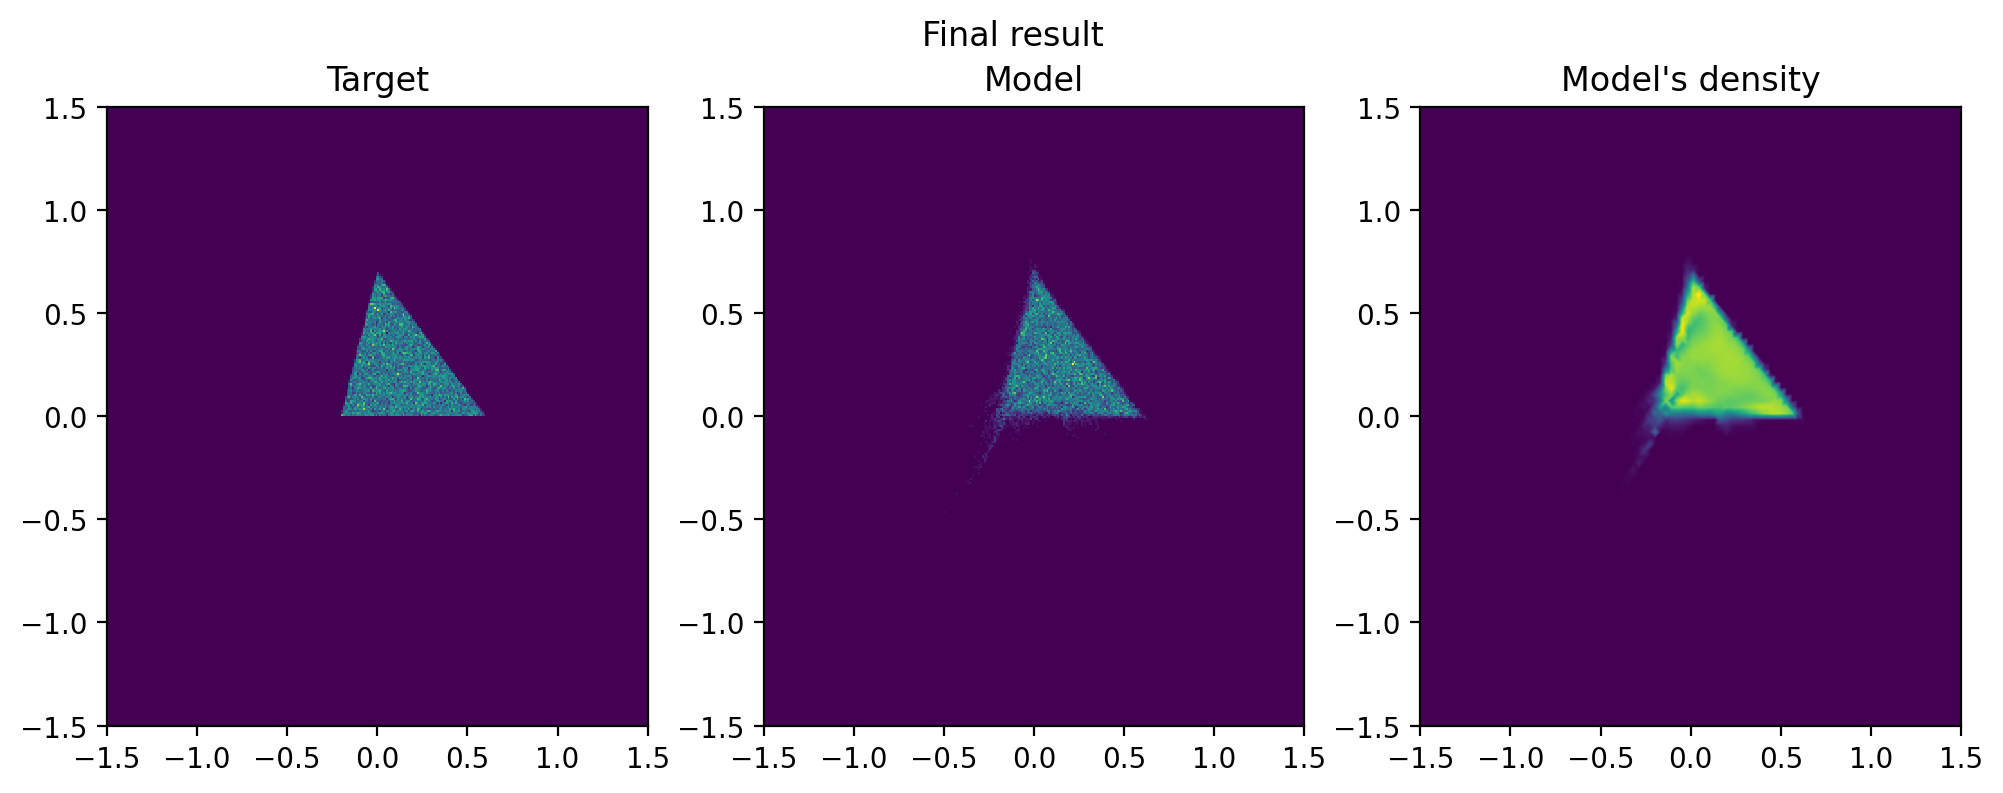

In [10]:
# Plot final result
def nf_final(model, viz_samples = 30000):
    model = model.to(device)
    target = get_batch(viz_samples).to(device)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=200)
    plt.suptitle(f'Final result')
    plt.tight_layout()
    
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1.5, 1.5, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T
    points = torch.tensor(points).type(torch.float32).to(device)
    
    trans_sample = model.sample(viz_samples).to(device)
    logp = model.log_prob(points)
    
    axes[0].set_title('Target')
    axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[1].set_title('Model')
    axes[1].hist2d(*trans_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[2].set_title("Model's density")
    # Set x-axis and y-axis limits
    axes[2].set_xlim(-1.5, 1.5)
    axes[2].set_ylim(-1.5, 1.5)
    axes[2].tricontourf(*points.detach().cpu().numpy().T, np.exp(logp.detach().cpu().numpy()), 200)

    
    plt.show()
    del model
    
nf_final(model_triangle)

### Concentric circles

In [11]:
from sklearn.datasets import make_circles
def get_batch(num_samples):
    """
    Generate random points in a two concentric circles distribution.
    """
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = torch.tensor(points).type(torch.float32)
    return x

#### Define the model
Since this distribution is more complex, we will use more transformations and the coupling layers will be deeper as well. In particular, we will use 14 transformations with 4 hidden layers in the scale and translation networks.

In [12]:
model_circles = NF(in_out_dim=2, hidden_dim=256, num_layers=4, num_transformations=14).to(device)
optimizer_circles = optim.Adam([p for p in model_circles.parameters() if p.requires_grad == True], lr=args['lr'])
print("The model has {} trainable parameters".format(sum(p.numel() for p in model_circles.parameters() if p.requires_grad)))

The model has 7404600 trainable parameters


#### Train the model

In [13]:
train_nf(model_circles, optimizer_circles)

Iter 100, Loss: 1.6260384321212769
Iter 200, Loss: 1.333736777305603
Iter 300, Loss: 1.1971023082733154
Iter 400, Loss: 1.0667856931686401
Iter 500, Loss: 1.0638788938522339
Iter 600, Loss: 1.0633981227874756
Iter 700, Loss: 1.0240906476974487
Iter 800, Loss: 0.978540301322937
Iter 900, Loss: 0.9431247115135193
Iter 1000, Loss: 0.9672176241874695
Iter 1100, Loss: 0.9127505421638489
Iter 1200, Loss: 0.9189710021018982
Iter 1300, Loss: 0.9558219313621521
Iter 1400, Loss: 0.9155853390693665
Iter 1500, Loss: 0.9115543961524963
Iter 1600, Loss: 0.8687881231307983
Iter 1700, Loss: 0.8502705693244934
Iter 1800, Loss: 0.9024258852005005
Iter 1900, Loss: 0.9223165512084961
Iter 2000, Loss: 0.9278758764266968
Iter 2100, Loss: 0.8633747696876526
Iter 2200, Loss: 0.8702006340026855
Iter 2300, Loss: 0.9031785130500793
Iter 2400, Loss: 0.8916794061660767
Iter 2500, Loss: 0.9062929749488831
Iter 2600, Loss: 0.8777302503585815
Iter 2700, Loss: 0.8630743026733398
Iter 2800, Loss: 0.8868929147720337
Ite

#### Plot the results

In [14]:
viz_nf(model_circles, 'circles_results')

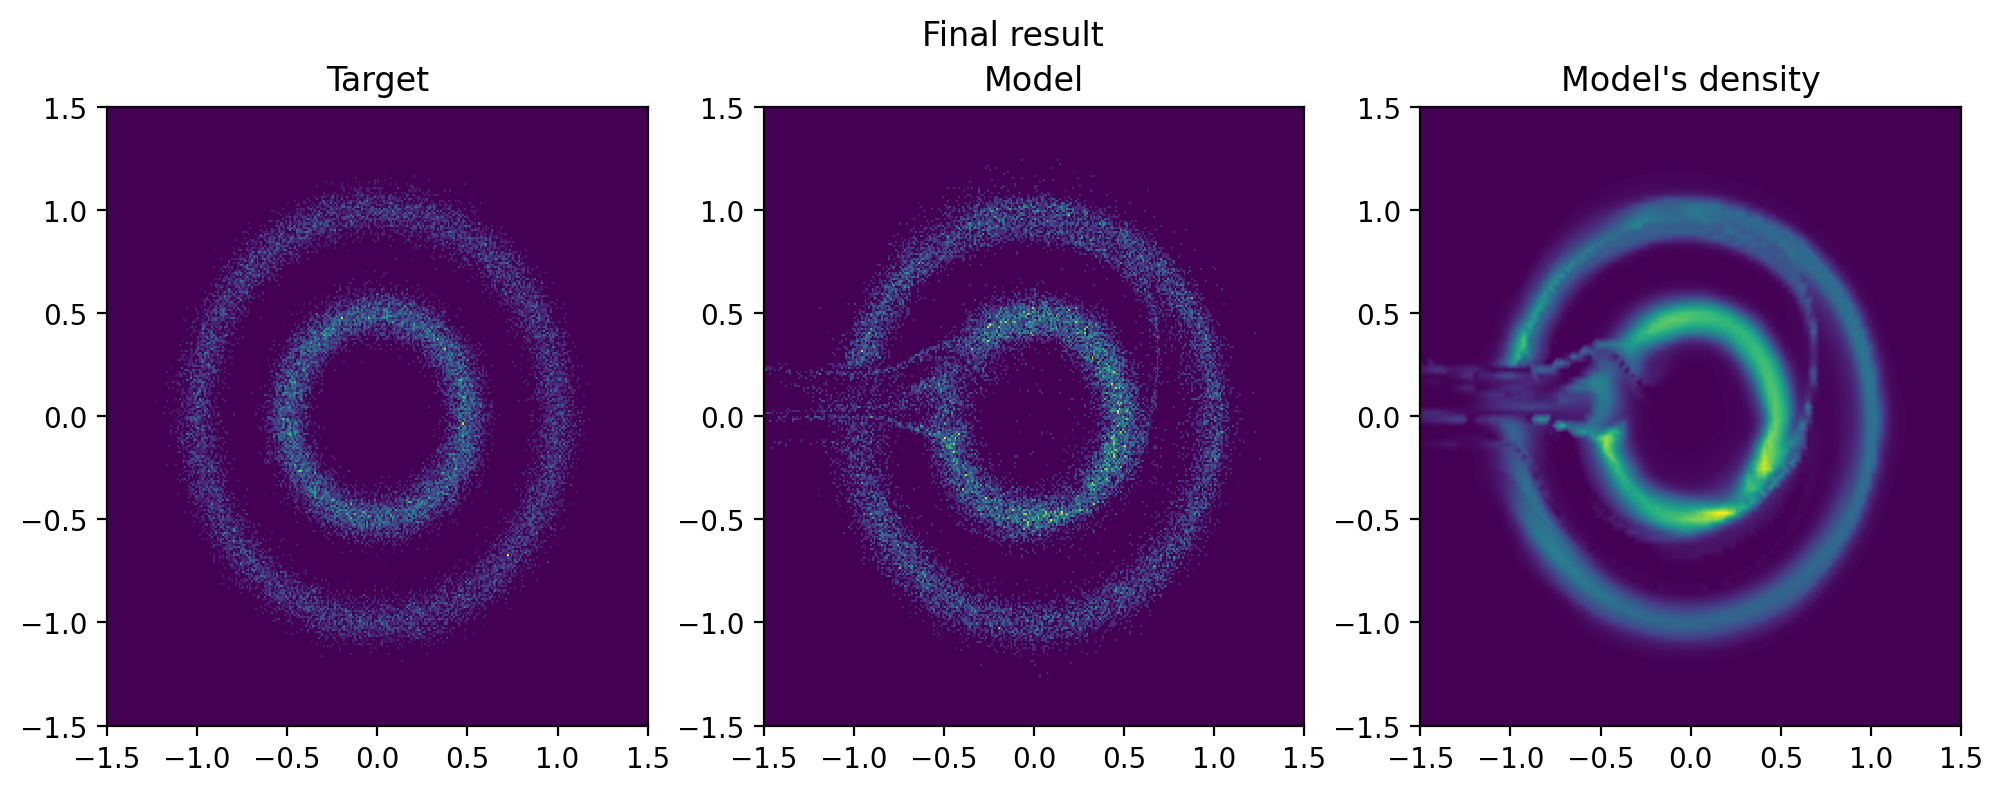

In [15]:
nf_final(model_circles)